In [76]:
# Import Dependencies
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.functional import to_pil_image
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import wandb
import cv2

In [77]:
# Check if GPU is available
if torch.cuda.is_available():
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)  # Assumes you have one GPU, change the index if needed
    print(f"GPU ({gpu_name}) is available.")
else:
    print('GPU not available')
    
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

GPU (NVIDIA GeForce RTX 3070 Ti Laptop GPU) is available.


In [78]:
wandb.init(project="image_colorization", config={
    "architecture": "GAN",
    "dataset": "CIFAR-100_VAL_2017",
})

Discriminator Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Generator Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Discriminator Loss,0.0
Generator Loss,100.0


In [79]:
def normalize_lab(img):
    """
    Normalizes a LAB image within the range of -1 to 1.

    Args:
        img (np.ndarray): A numpy array representing the LAB image.

    Returns:
        np.ndarray: A numpy array representing the normalized LAB image.
    """
    img_l, img_a, img_b = torch.split(img, 1, 0) # SPlit the 3d array into 3 1d arrays
    img_l = (2 * img_l / 100) - 1 # Normalize values between 0 and 1 by dividing by 100
    img_a = (img_a / 128) # Normalize between 0 and 1 as well
    img_b = (img_b / 128) # Same for b channel
    full = torch.stack([img_l, img_a, img_b], dim=1)
    return full[0]

def denormalize_lab(img):
    """
    Denormalizes a LAB image within the range of -1 to 1.

    Args:
        img (np.ndarray): A numpy array representing the LAB image.

    Returns:
        np.ndarray: A numpy array representing the denormalized LAB image.
    """
    img_l, img_a, img_b = torch.split(img, 1, 0)
    img_l = (img_l + 1) * 50
    img_a = (img_a) * 128
    img_b = (img_b) * 128
    full = torch.stack([img_l, img_a, img_b], dim=1)
    return full[0]
    

class ColorizationDataset(Dataset):
    def __init__(self, root_dir, base_images):
        self.root_dir = root_dir
        self.base_images = base_images
        self.bw_folder = os.path.join(root_dir, 'bw')
        self.color_folder = os.path.join(root_dir, 'color')
        self.file_list = os.listdir(base_images)

    def __len__(self):
        return len(self.file_list)
    
    def rgb_to_lab(self, rgb_image):
        rgb_img = np.array(rgb_image)
        lab_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
        lab_img = lab_img.transpose(2,1,0)
        lab_img_torch = torch.from_numpy(lab_img)
        return lab_img_torch[:1,:,:].to(dtype=torch.float32), lab_img_torch[1:,:,:].to(dtype=torch.float32)
        
    def __getitem__(self, idx):
        colored_path = os.path.join(self.color_folder, f'color_{self.file_list[idx]}')
        colored_image = Image.open(colored_path)
        bw_image, ab_channels = self.rgb_to_lab(colored_image)
        return bw_image.to(device), ab_channels.to(device)

In [80]:
# Instantiate the dataset
dataset = ColorizationDataset(root_dir='Data/MS COCO GR_RGB', base_images='Data/MS COCO/MS COCO/val2017')

# Instantiate a PyTorch DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

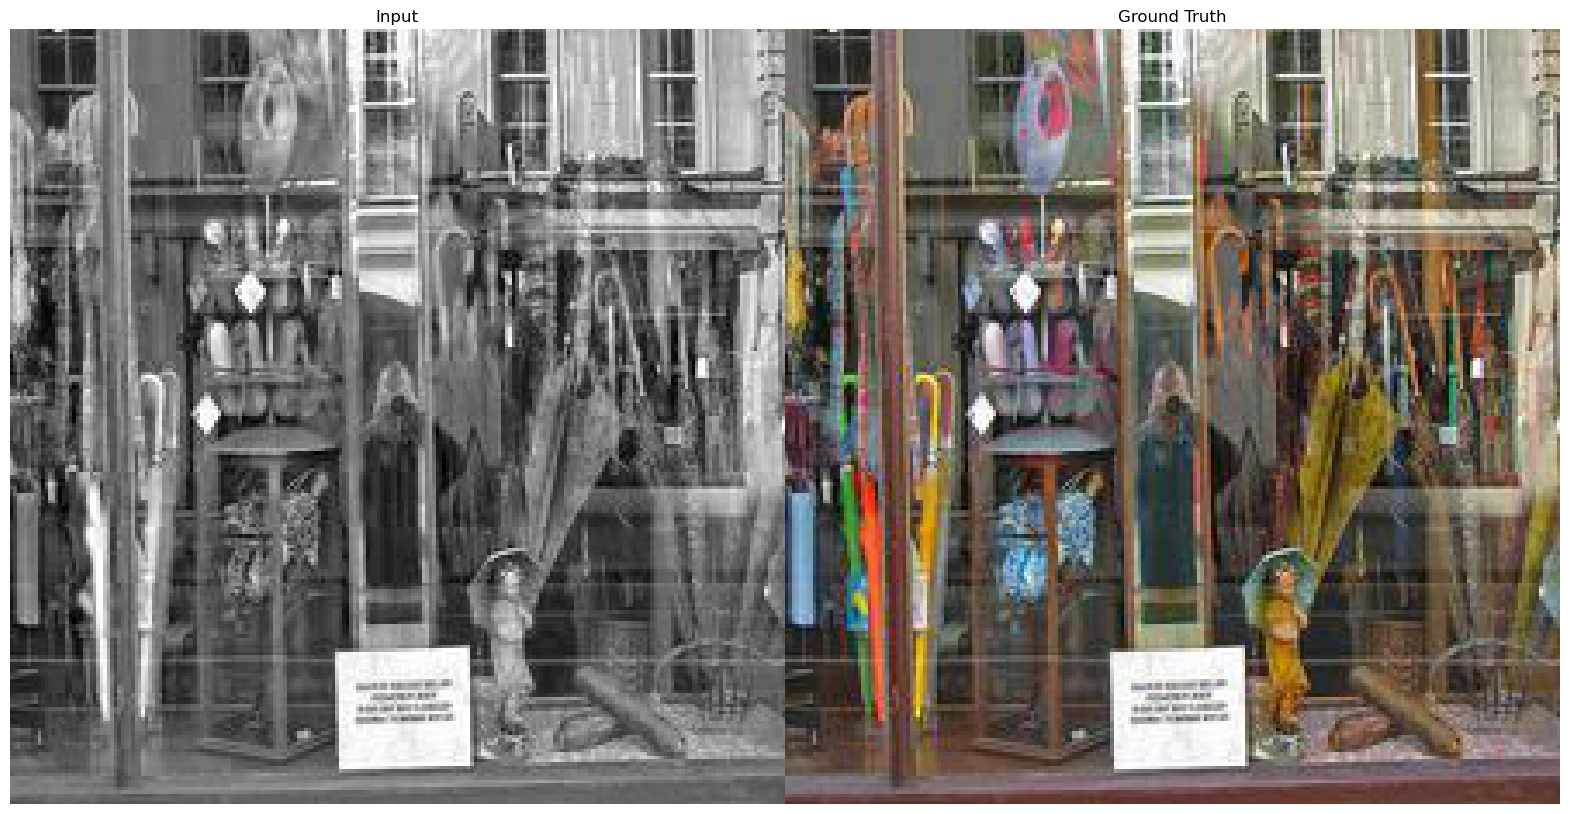

In [81]:
# Show a sample from dataset
# Set a larger figure size
plt.figure(figsize=(20, 15), dpi=100)

# Iterate over the dataloader
for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
    a_channel, b_channel = torch.split(colored_images[0], 1, 0)
    full_norm = torch.stack([bw_images[0], a_channel, b_channel], dim=1).cpu()
    full_norm = full_norm[0].to(torch.uint8)
    combined_rgb = cv2.cvtColor(full_norm.numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB

    # Plot black and white image
    plt.subplot(1, 2, 1)
    plt.title('Input')
    plt.imshow(np.rot90(combined_rgb[:,:,:1], 3), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title('Ground Truth')
    plt.imshow(np.rot90(combined_rgb, 3))
    plt.axis('off')

    # Adjust spacing to eliminate the gap between subplots
    plt.subplots_adjust(wspace=.001, hspace=0)

    # Display only one batch for demonstration purposes
    break
plt.show()

In [83]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 2, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x

# Instantiate the model
model_gen = GeneratorModel()
batch_size_gen = 32
input_shape_gen = (batch_size_gen, 1, 224, 224)
# Print the model summary
model_gen.to(device)
summary(model_gen, input_shape_gen)

Layer (type:depth-idx)                   Output Shape              Param #
GeneratorModel                           [32, 2, 224, 224]         --
├─Sequential: 1-1                        [32, 512, 28, 28]         --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        640
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [32, 64, 224, 224]        128
│    └─Dropout: 2-4                      [32, 64, 224, 224]        --
│    └─Conv2d: 2-5                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-6                         [32, 128, 112, 112]       --
│    └─BatchNorm2d: 2-7                  [32, 128, 112, 112]       256
│    └─Conv2d: 2-8                       [32, 256, 56, 56]         295,168
│    └─ReLU: 2-9                         [32, 256, 56, 56]         --
│    └─BatchNorm2d: 2-10                 [32, 256, 56, 56]         512
│    └─Conv2d: 2-11                      [32, 512, 28, 28]         1,180

In [85]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),
        )
        self.decoder = nn.Sequential(
            nn.Flatten(1, 3),
            nn.Linear(6400, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model_disc = DiscriminatorModel()
batch_size_disc = 64
# Instantiate the model
input_shape_disc = (batch_size_disc, 2, 224, 224)
# Print the model summary
model_disc.to(device)
summary(model_disc, input_shape_disc)

Layer (type:depth-idx)                   Output Shape              Param #
DiscriminatorModel                       [64, 1]                   --
├─Sequential: 1-1                        [64, 256, 5, 5]           --
│    └─Conv2d: 2-1                       [64, 96, 54, 54]          23,328
│    └─ReLU: 2-2                         [64, 96, 54, 54]          --
│    └─MaxPool2d: 2-3                    [64, 96, 26, 26]          --
│    └─Conv2d: 2-4                       [64, 128, 26, 26]         307,328
│    └─ReLU: 2-5                         [64, 128, 26, 26]         --
│    └─MaxPool2d: 2-6                    [64, 128, 12, 12]         --
│    └─Conv2d: 2-7                       [64, 256, 12, 12]         295,168
│    └─ReLU: 2-8                         [64, 256, 12, 12]         --
│    └─Conv2d: 2-9                       [64, 384, 12, 12]         885,120
│    └─ReLU: 2-10                        [64, 384, 12, 12]         --
│    └─Conv2d: 2-11                      [64, 256, 12, 12]        

In [71]:
print(f'ESTIMATED VRAM USAGE FOR FORWARD PASS:\n{(156 + 2680) / 1000} GB')

ESTIMATED VRAM USAGE FOR FORWARD PASS:
2.836 GB


In [90]:
# a_channel, b_channel = torch.split(colored_images[0], 1, 0)
#     full_norm = torch.stack([bw_images[0], a_channel, b_channel], dim=1).cpu()
#     full_norm = full_norm[0].to(torch.uint8)
#     combined_rgb = cv2.cvtColor(full_norm.numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
# Function for logging sample images to wandb
def log_pred(bw_image, pred_image, gt_image):
    a_channel_pred, b_channel_pred = torch.split(pred_image, 1, 0)
    full_pred = torch.stack([bw_image, a_channel_pred, b_channel_pred], dim=1).cpu().to(torch.uint8)
    combined_rgb_pred = cv2.cvtColor(full_pred[0].numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
    
    # Convert them all to 8 bit integers
    a_channel_gt, b_channel_gt = torch.split(gt_image, 1, 0) # Split the A and B channels into two separate tensors
    lab_img_gt = torch.stack([bw_image, a_channel_gt, b_channel_gt], dim=1).cpu().to(torch.uint8) # Combine them all into the full LAB image
    combined_rgb = cv2.cvtColor(lab_img_gt[0].numpy().transpose(1,2,0), cv2.COLOR_Lab2RGB) # Convert the colorspace into the RGB format from LAB
    
    wandb.log({
        "input_image": wandb.Image(np.rot90(combined_rgb[:,:,:1], 3)),
        "reconstruction_image": wandb.Image(np.rot90(combined_rgb_pred, 3)),
        "ground_truth_image": wandb.Image(np.rot90(combined_rgb, 3)),
    })
    
# Define the loss function and optimizer
criterion = nn.BCELoss()

# Adam optimizer for best performance
optimizer_gen = optim.Adam(model_gen.parameters(), lr=0.001)
optimizer_disc = optim.Adam(model_disc.parameters(), lr=0.001)

# Training loop
num_epochs = 20
eps = 1e-6
SEED = 420

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (bw_images, colored_images) in enumerate(dataloader):
        
        gen_inputs = bw_images[:32] # Take the first half for the generator
        gen_inputs_len = len(gen_inputs) # Gets the length to creates the labels
        real_inputs = colored_images[32:] # Other half is for the ground truth
        real_inputs_len = len(real_inputs) # Gets the length for the labels
        
        real_label = torch.ones(real_inputs_len, requires_grad=False).reshape(real_inputs_len, 1).to(device) # Labels for the ground truths
        fake_label = torch.zeros(gen_inputs_len, requires_grad=False).reshape(gen_inputs_len, 1).to(device) # Labels for the generator predictions
        full_labels = torch.cat((real_label, fake_label), dim=0)
        
        gen_outputs = model_gen(gen_inputs) # These will be fed into the model
        full_disc_inputs = torch.cat((real_inputs, gen_outputs), dim=0)
        
        # Shuffle the inputs
        shuffled_positions = torch.randperm(full_disc_inputs.shape[0])
        inputs_shuffled = full_disc_inputs[shuffled_positions]
        labels_shuffled = full_labels[shuffled_positions]
        
        # Forward pass using only real inputs
        optimizer_disc.zero_grad()
        disc_outputs = model_disc(inputs_shuffled)
        loss_disc = criterion(disc_outputs, labels_shuffled) # Compute loss
        loss_disc.backward() # Propagate error back through model
        optimizer_disc.step() # Update weights for discriminator
        
        # Forward pass using only fake inputs
        optimizer_gen.zero_grad()
        disc_outputs = model_disc(inputs_shuffled)
        loss_gen = 1 - criterion(disc_outputs, labels_shuffled)
        loss_gen.backward() # Propagate error back through generator model
        optimizer_gen.step() # Update generator weights
        
        # Log results
        wandb.log({"Discriminator Loss":loss_disc, "Generator Loss":loss_gen})
        
        # Log results
        if batch_idx % 5 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Discriminator Loss: {loss_disc.item()}, Generator Loss: {loss_gen.item()}')
        if batch_idx % 80 == 0:
            log_pred(bw_images[0], gen_outputs[0], colored_images[0])
            

# Save the trained model
torch.save(model_gen.state_dict(), 'colorization_model_5.pth')
wandb.finish()